### Data preprocessing

In [1]:
### Let's read a sample audio using librosa
import librosa
audio_file_path='UrbanSound8K/100263-2-0-3.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [2]:
print(librosa_audio_data)

[ 0.00330576  0.00468387  0.00360455 ... -0.0037562  -0.00348641
 -0.00356705]


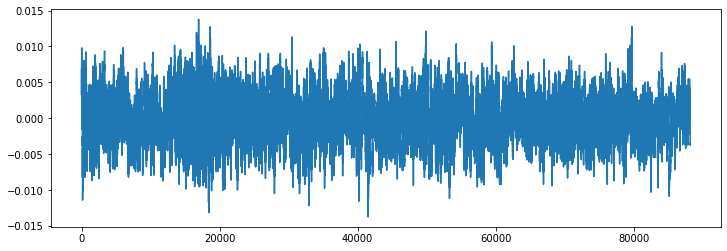

In [3]:
### Lets plot the librosa audio data
import matplotlib.pyplot as plt
# Original audio with 1 channel 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

#### Observation

Here, Librosa converts the signal to mono, meaning the channel will always be 1

In [4]:
### let us read it with scipy
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path) 

In [5]:
wave_audio

array([[ 194,  100],
       [ 179,  113],
       [ 160,  124],
       ...,
       [-143,  -87],
       [-134,  -91],
       [-110,  -98]], dtype=int16)

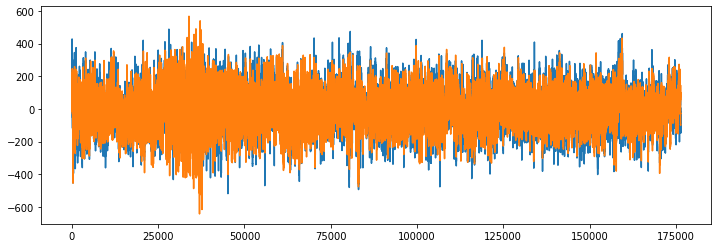

In [6]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

#### Data extraction

Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [7]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [8]:
mfccs

array([[-4.75309448e+02, -4.51539337e+02, -4.49755127e+02, ...,
        -4.77412781e+02, -4.73848846e+02, -4.91058777e+02],
       [ 1.15936340e+02,  1.12366516e+02,  1.12244164e+02, ...,
         1.12045395e+02,  1.11286507e+02,  1.03281311e+02],
       [-1.89592590e+01, -2.56048889e+01, -3.12500191e+01, ...,
        -9.15441895e+00, -9.77182007e+00, -4.79179764e+00],
       ...,
       [-2.60460114e+00, -2.85800481e+00, -4.48165226e+00, ...,
        -1.90692782e-01,  3.74826121e+00,  7.53867531e+00],
       [-6.84984028e-01, -9.56210017e-01, -1.20930505e+00, ...,
        -1.23640239e-01,  6.06250167e-01,  2.67598557e+00],
       [-9.39640224e-01,  1.04388285e+00,  6.72155762e+00, ...,
        -2.33736587e+00, -4.64974403e+00, -3.15546131e+00]], dtype=float32)

In [9]:
#### Extracting MFCC's For every audio file
import pandas as pd
import os
import librosa

audio_dataset_path='UrbanSound8K/audio/'
metadata=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [10]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [11]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [04:22, 11.80it/s]/Users/snigdhakakkar/opt/anaconda2/envs/tf/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8326it [10:25, 22.79it/s]/Users/snigdhakakkar/opt/anaconda2/envs/tf/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
/Users/snigdhakakkar/opt/anaconda2/envs/tf/lib/python3.7/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [10:51, 13.40it/s]


In [12]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

feature             class
0  [-218.18938, 71.38549, -131.49442, -52.25892, ...          dog_bark
1  [-425.05234, 110.67095, -54.192833, 62.045406,...  children_playing
2  [-459.82623, 122.82864, -47.908062, 53.302677,...  children_playing
3  [-414.82184, 102.94826, -36.65685, 54.170742, ...  children_playing
4  [-447.60776, 115.08627, -53.74607, 61.55309, 1...  children_playing

In [13]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [14]:
X.shape

(8732, 40)

In [15]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [16]:
### Label Encoding
y=np.array(pd.get_dummies(y))

### Label Encoder
#from tensorflow.keras.utils import to_categorical
#from sklearn.preprocessing import LabelEncoder
#labelencoder=LabelEncoder()
#y=to_categorical(labelencoder.fit_transform(y))

In [17]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [18]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [19]:
X_train

array([[-1.3211458e+02,  1.1391494e+02, -2.3927406e+01, ...,
         3.3260243e+00, -1.4790288e+00,  2.8912868e+00],
       [-1.4296137e+01,  9.1951004e+01, -8.6025953e+00, ...,
        -3.3708370e+00, -5.2008624e+00, -1.5975088e+00],
       [-4.9827820e+01,  1.8449357e-01, -2.0364500e+01, ...,
         2.0259936e+00, -8.3159244e-01,  2.7930872e+00],
       ...,
       [-4.2723694e+02,  9.2938095e+01,  2.8287885e+00, ...,
         8.1411356e-01,  6.6066742e-01,  7.8365982e-01],
       [-1.4640692e+02,  1.3716916e+02, -3.4362492e+01, ...,
         1.3839476e+00, -1.9667519e+00, -8.8792086e-01],
       [-4.2171307e+02,  2.1160454e+02,  2.5852380e+00, ...,
        -5.1338639e+00, -3.6135261e+00, -1.3413876e+00]], dtype=float32)

In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6985, 40), (6985, 10), (1747, 40), (1747, 10))

### Model creation

In [21]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [23]:
### No of classes
num_labels=y.shape[1]

In [24]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

2022-05-25 11:54:23.804860: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [26]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [28]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
219/219 [==============================] - ETA: 0s - loss: 0.9787 - accuracy: 0.6815
Epoch 1: val_loss improved from inf to 0.82270, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 5ms/step - loss: 0.9787 - accuracy: 0.6815 - val_loss: 0.8227 - val_accuracy: 0.7464
Epoch 2/100
207/219 [===========================>..] - ETA: 0s - loss: 0.9618 - accuracy: 0.6875
Epoch 2: val_loss improved from 0.82270 to 0.79560, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 5ms/step - loss: 0.9636 - accuracy: 0.6868 - val_loss: 0.7956 - val_accuracy: 0.7401
Epoch 3/100
202/219 [==========================>...] - ETA: 0s - loss: 0.9609 - accuracy: 0.6923
Epoch 3: val_loss improved from 0.79560 to 0.78348, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 0.9592 - accuracy: 0.6925 - val_loss: 0.7835 - val_accuracy: 0.7584

Epoch 29/100
203/219 [==========================>...] - ETA: 0s - loss: 0.9383 - accuracy: 0.6978
Epoch 29: val_loss did not improve from 0.74472
219/219 [==============================] - 1s 3ms/step - loss: 0.9398 - accuracy: 0.6978 - val_loss: 0.7704 - val_accuracy: 0.7642
Epoch 30/100
210/219 [===========================>..] - ETA: 0s - loss: 0.9242 - accuracy: 0.6978
Epoch 30: val_loss did not improve from 0.74472
219/219 [==============================] - 1s 5ms/step - loss: 0.9253 - accuracy: 0.6965 - val_loss: 0.7747 - val_accuracy: 0.7579
Epoch 31/100
202/219 [==========================>...] - ETA: 0s - loss: 0.9376 - accuracy: 0.7014
Epoch 31: val_loss did not improve from 0.74472
219/219 [==============================] - 1s 4ms/step - loss: 0.9354 - accuracy: 0.7014 - val_loss: 0.7662 - val_accuracy: 0.7642
Epoch 32/100
209/219 [===========================>..] - ETA: 0s - loss: 0.9295 - accuracy: 0.6975
Epoch 32: val_loss did not improve from 0.74472
219/219 [==============

210/219 [===========================>..] - ETA: 0s - loss: 0.9079 - accuracy: 0.7049
Epoch 58: val_loss did not improve from 0.72139
219/219 [==============================] - 1s 4ms/step - loss: 0.9100 - accuracy: 0.7039 - val_loss: 0.7436 - val_accuracy: 0.7768
Epoch 59/100
219/219 [==============================] - ETA: 0s - loss: 0.9125 - accuracy: 0.6999
Epoch 59: val_loss did not improve from 0.72139
219/219 [==============================] - 1s 4ms/step - loss: 0.9125 - accuracy: 0.6999 - val_loss: 0.7356 - val_accuracy: 0.7762
Epoch 60/100
207/219 [===========================>..] - ETA: 0s - loss: 0.9086 - accuracy: 0.7104
Epoch 60: val_loss did not improve from 0.72139
219/219 [==============================] - 1s 4ms/step - loss: 0.9157 - accuracy: 0.7078 - val_loss: 0.7908 - val_accuracy: 0.7447
Epoch 61/100
203/219 [==========================>...] - ETA: 0s - loss: 0.9294 - accuracy: 0.6950
Epoch 61: val_loss did not improve from 0.72139
219/219 [===========================

Epoch 87/100
207/219 [===========================>..] - ETA: 0s - loss: 0.9024 - accuracy: 0.7062
Epoch 87: val_loss did not improve from 0.70481
219/219 [==============================] - 1s 5ms/step - loss: 0.8976 - accuracy: 0.7074 - val_loss: 0.7300 - val_accuracy: 0.7750
Epoch 88/100
207/219 [===========================>..] - ETA: 0s - loss: 0.8918 - accuracy: 0.7139
Epoch 88: val_loss improved from 0.70481 to 0.70033, saving model to saved_models/audio_classification.hdf5
219/219 [==============================] - 1s 4ms/step - loss: 0.8920 - accuracy: 0.7137 - val_loss: 0.7003 - val_accuracy: 0.7768
Epoch 89/100
219/219 [==============================] - ETA: 0s - loss: 0.9134 - accuracy: 0.7079
Epoch 89: val_loss did not improve from 0.70033
219/219 [==============================] - 1s 4ms/step - loss: 0.9134 - accuracy: 0.7079 - val_loss: 0.7445 - val_accuracy: 0.7584
Epoch 90/100
213/219 [============================>.] - ETA: 0s - loss: 0.8883 - accuracy: 0.7057
Epoch 90: v

In [29]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7750429511070251


In [31]:
filename="UrbanSound8K/dog_bark.wav"

In [34]:
prediction_feature = features_extractor(filename)
prediction_feature.reshape(1,-1).shape

(1, 40)

In [38]:
y_pred = model.predict(prediction_feature)
y_pred = np.round(y_pred).astype(int)

ValueError: Exception encountered when calling layer "sequential" (type Sequential).

Input 0 of layer "dense" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)

Call arguments received:
  • inputs=tf.Tensor(shape=(None,), dtype=float32)
  • training=False
  • mask=None

### Testing some new audio data